https://www.kaggle.com/code/khyeh0719/ptb-xl-dataset-wrangling/notebook https://www.kaggle.com/code/henrytang05/ecg-detection-1d-cnn

Hybrid model with mean signal and all leads

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annbarmekouar","key":"af98a5925614c7c43ac8114af032e739"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

 99% 1.71G/1.72G [00:21<00:00, 42.7MB/s]
100% 1.72G/1.72G [00:21<00:00, 86.6MB/s]


In [ ]:
!unzip ptb-xl-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19342_hr.dat  
  inflating: ptb-x

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import wfdb
import os
import ast

In [ ]:
path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'
ecg_data = pd.read_csv(path + '/ptbxl_database.csv', index_col='ecg_id')

scp_data = pd.read_csv(path + '/scp_statements.csv', index_col=0)
scp_data = scp_data[scp_data.diagnostic == 1]

In [ ]:
def load_signals(df, path):
    data = [wfdb.rdsamp(os.path.join(path, link)) for link in df.filename_lr]
    data = np.array([signal for signal, meta in data])
    return data

ecg_signal = load_signals(ecg_data, path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import wfdb
import os
import pandas as pd

# Define the path and load your datasets
path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'
ecg_data = pd.read_csv(path + '/ptbxl_database.csv', index_col='ecg_id')

# Define the bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Define the load_signal function to load ECG signals using the WFDB package
def load_signal(filename, path):
    full_path = os.path.join(path, filename)
    signal, _ = wfdb.rdsamp(full_path)
    return signal

# Define a function to process ECG signals for all patients and leads
def process_all_patients_records(ecg_data, path, sampling_rate=100):
    all_patients_mean_heartbeats = []  # List to store mean heartbeat data for all patients

    # Iterate over each patient record
    for index, row in ecg_data.iterrows():
        filename = row['filename_lr']
        ecg_signal = load_signal(filename, path)
        patient_mean_heartbeats = []  # List to store mean heartbeat data for each lead of the current patient

        # Iterate over each lead
        for lead_index in range(ecg_signal.shape[1]):
            lead_signal = ecg_signal[:, lead_index]
            normalized_lead = (lead_signal - np.min(lead_signal)) / (np.max(lead_signal) - np.min(lead_signal))
            filtered_lead = bandpass_filter(normalized_lead, 0.5, 40.0, sampling_rate, order=1)

            # Find R-peaks
            r_peaks, _ = find_peaks(filtered_lead, distance=int(sampling_rate * 0.6), prominence=0.1)
            heartbeats = []

            # Extract heartbeats
            for r_peak in r_peaks:
                if r_peak - int(0.2 * sampling_rate) >= 0 and r_peak + int(0.4 * sampling_rate) < len(filtered_lead):
                    heartbeat = filtered_lead[r_peak - int(0.2 * sampling_rate):r_peak + int(0.4 * sampling_rate)]
                    heartbeats.append(heartbeat)

            # Calculate and store the mean heartbeat if there are any heartbeats
            if heartbeats:
                mean_heartbeat = np.mean(np.vstack(heartbeats), axis=0)
                patient_mean_heartbeats.append(mean_heartbeat)
            else:
                # Append a zero-filled array if no heartbeats are detected for consistency in shape
                patient_mean_heartbeats.append(np.zeros((int(0.6 * sampling_rate),)))

        # Append the patient's mean heartbeats to the main list
        all_patients_mean_heartbeats.append(patient_mean_heartbeats)

    return np.array(all_patients_mean_heartbeats)

# Process and store mean heartbeat data for all patients
all_patients_mean_heartbeats = process_all_patients_records(ecg_data, path)

# all_patients_mean_heartbeats now stores the mean heartbeat data for each lead and patient


<ipython-input-9-de9eb48136aa>:40: RuntimeWarning: invalid value encountered in divide
  normalized_lead = (lead_signal - np.min(lead_signal)) / (np.max(lead_signal) - np.min(lead_signal))


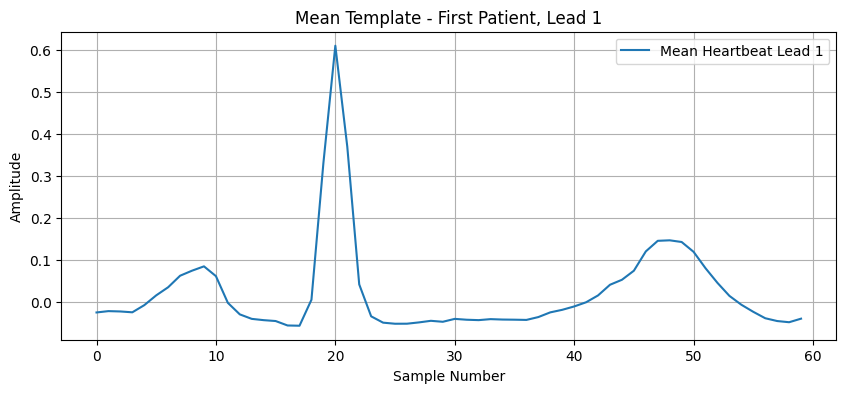

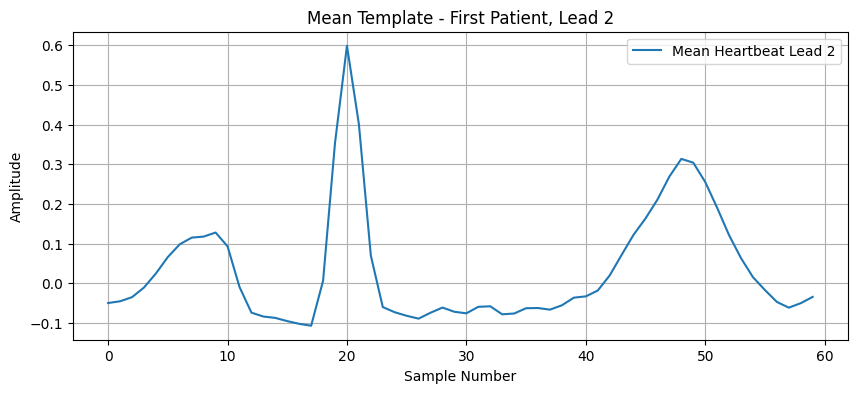

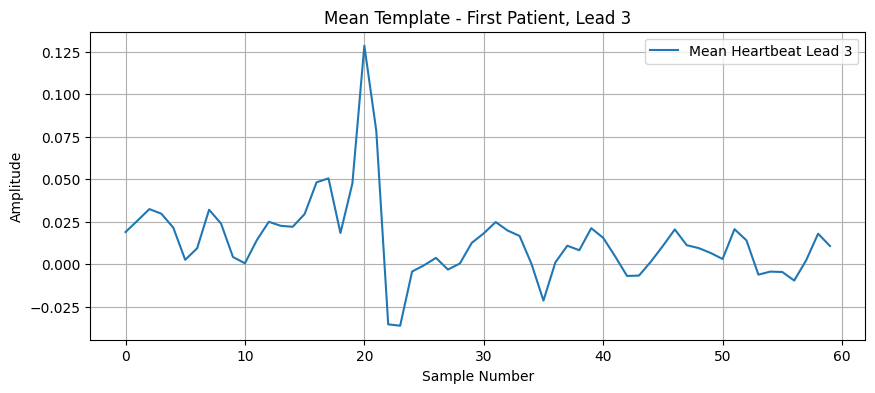

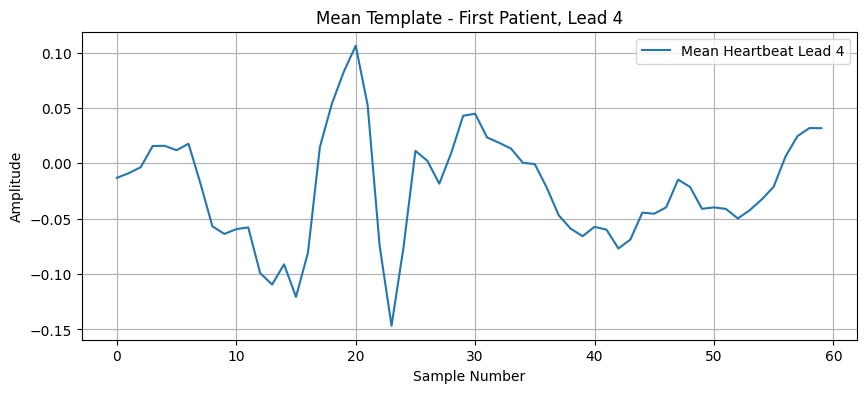

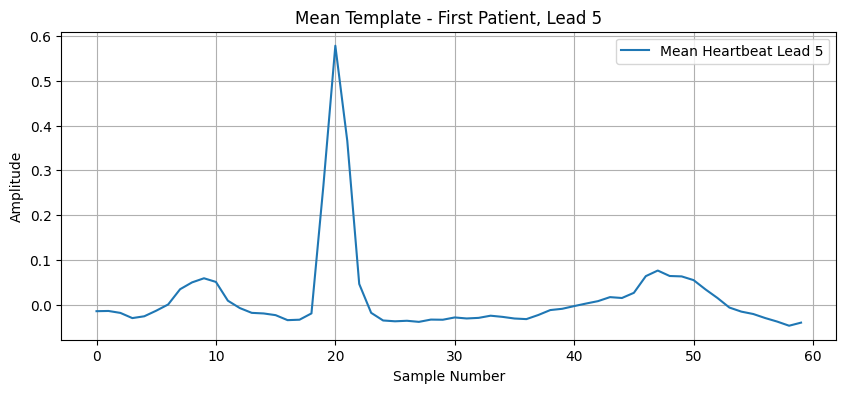

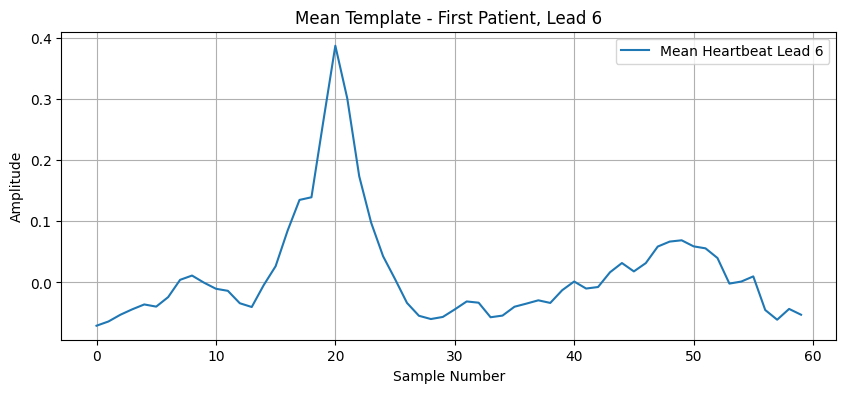

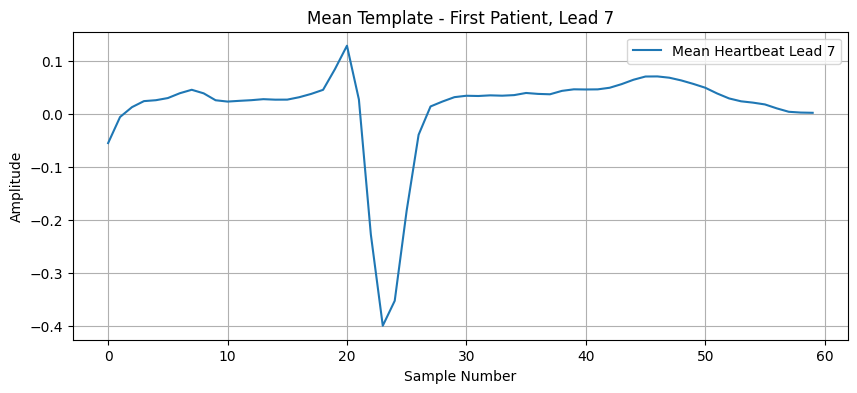

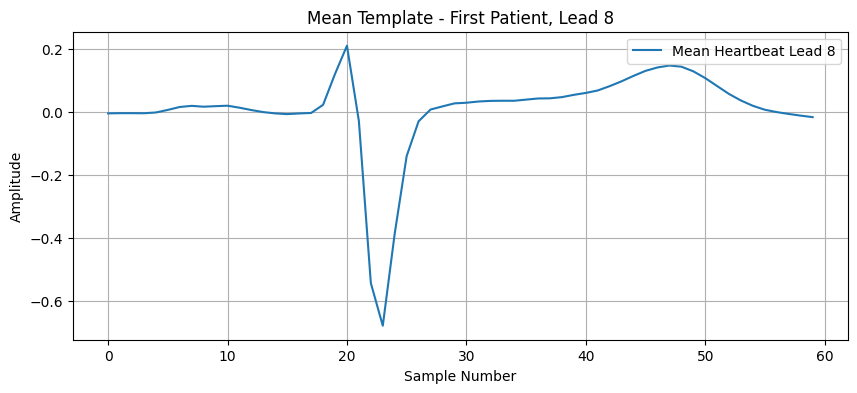

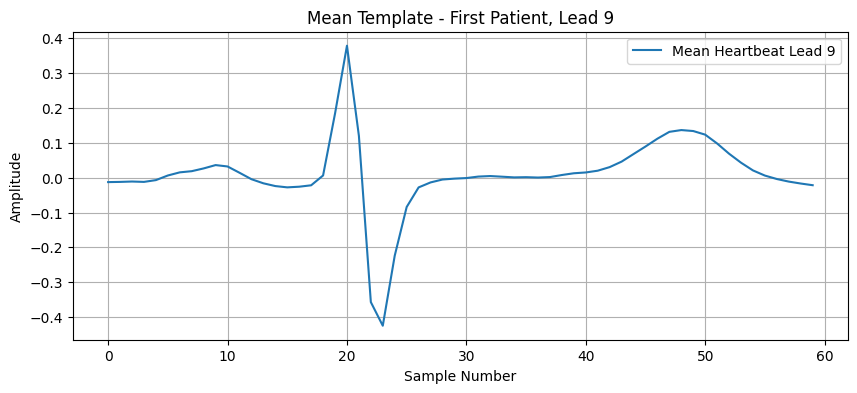

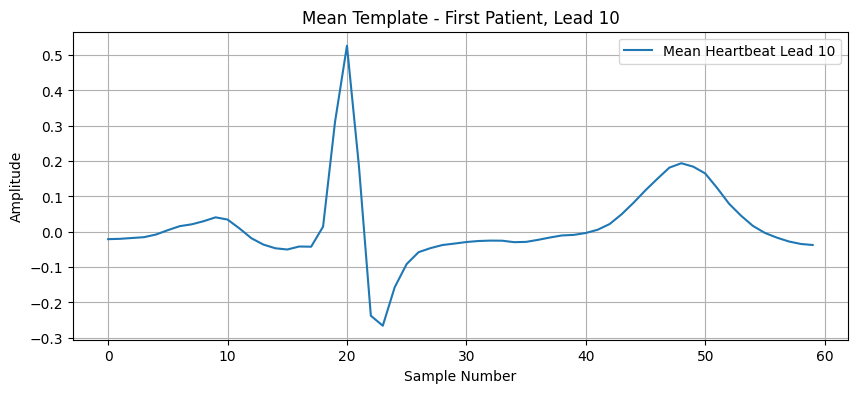

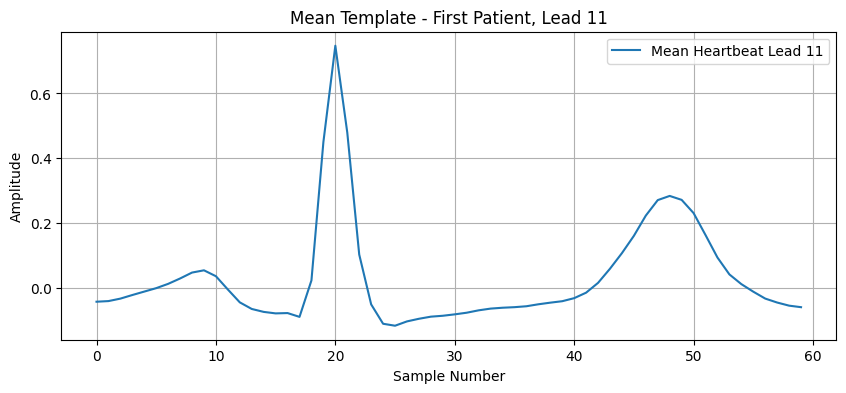

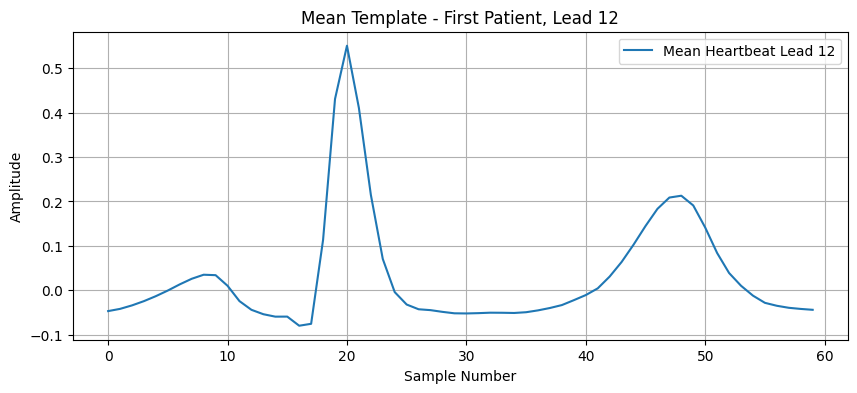

In [ ]:
import matplotlib.pyplot as plt

# Assuming all_patients_mean_heartbeats is available and contains the processed data

# Get the mean heartbeat data for the first patient
first_patient_mean_heartbeats = all_patients_mean_heartbeats[0]

# Plotting the mean heartbeat for each lead of the first patient
for lead_index, mean_heartbeat in enumerate(first_patient_mean_heartbeats):
    plt.figure(figsize=(10, 4))
    plt.plot(mean_heartbeat, label=f'Mean Heartbeat Lead {lead_index + 1}')
    plt.title(f'Mean Template - First Patient, Lead {lead_index + 1}')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
print(ecg_signal.shape)
print(all_patients_mean_heartbeats.shape)

(21837, 1000, 12)
(21837, 12, 60)


In [ ]:
# number of different values
ecg_data[[col for col in ecg_data.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

In [ ]:
# number of null values
ecg_data.isnull().sum()

patient_id                          0
age                                89
sex                                 0
height                          14854
weight                          12408
nurse                            1509
site                               18
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8505
infarction_stadium1             16211
infarction_stadium2             21734
validated_by                     9411
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20230
static_noise                    18575
burst_noise                     21224
electrodes_problems             21807
extra_beats                     19883
pacemaker                       21544
strat_fold                          0
filename_lr                         0
filename_hr 

In [ ]:
ecg_data

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [ ]:
ecg_data['scp_codes'] = ecg_data['scp_codes'].apply(lambda x: ast.literal_eval(x))

In [ ]:
import pandas as pd
def superclasses(scp):
    res = set()
    for k in scp.keys():
        if k in scp_data.index:
            res.add(scp_data.loc[k].diagnostic_class)

    return list(res)

ecg_data['scp_classes'] = ecg_data['scp_codes'].apply(superclasses)

In [ ]:
Z = pd.DataFrame(0, index=ecg_data.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')

for i in Z.index:
    for j in ecg_data.loc[i, 'scp_classes']:
        Z.loc[i, j] = 1

Z['NORM'] = Z['NORM'].fillna(0)
Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


In [ ]:
ecg_data['binary_label'] = Z.drop(columns=['NORM']).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

In [ ]:
print(ecg_signal.shape)
print(all_patients_mean_heartbeats.shape)

(21837, 1000, 12)
(21837, 12, 60)


In [ ]:
from sklearn.model_selection import train_test_split

# Binary classification: 1 for any condition other than 'NORM', 0 for 'NORM'
# Assuming that if any of the conditions other than 'NORM' is present, it's considered a positive case
y = Z[['MI', 'STTC', 'CD', 'HYP']].any(axis=1).astype(int).values

# Confirm that 'ecg_signal_shortened' and 'y' have the same length
all_patients_mean_heartbeats_shortened = all_patients_mean_heartbeats[:, :, :]
print(all_patients_mean_heartbeats_shortened.shape[0], y.shape[0])

all_patients_mean_heartbeats_expanded = np.expand_dims(all_patients_mean_heartbeats_shortened, axis=-1)

# Now you can split your dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_patients_mean_heartbeats_expanded, y, test_size=0.2, random_state=42, shuffle=False
)

# Check the final shapes
print(X_train.shape)
print(y_test.shape)

21837 21837
(17469, 12, 60, 1)
(4368,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Assuming 'ecg_signal' is your full signal data with the shape (samples, timesteps, leads)
# and you have already shortened it to 60 timesteps with all 12 leads

# You want to scale all values to the [0,1] range for all leads.
scaler = MinMaxScaler(feature_range=(0, 1))

# Flatten the data to 2D for scaling: each row is one sample at one timestep for all leads
num_samples, num_timesteps, num_leads = all_patients_mean_heartbeats.shape
all_patients_mean_heartbeats_flattened = all_patients_mean_heartbeats.reshape(num_samples * num_timesteps, num_leads)

# Fit the scaler on the training set (only scale with respect to the training data)
split_idx = int(num_samples * 0.8)
scaler.fit(all_patients_mean_heartbeats_flattened[:split_idx * num_timesteps])

# Transform the entire dataset (both training and test data)
all_patients_mean_heartbeats_scaled_flattened = scaler.transform(all_patients_mean_heartbeats_flattened)

# Reshape back to 3D after scaling
all_patients_mean_heartbeats_scaled_flattened = all_patients_mean_heartbeats_scaled_flattened.reshape(num_samples, num_timesteps, num_leads)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 60, 12))
print(X_train.shape)

(17469, 60, 12)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# Initialize the model
model_hybridbis2 = Sequential()

# Assuming the input_shape is known for the ECG data, for example (60, 12)
input_shape = (60, 12)  # Replace with the actual shape

# First convolutional layer
model_hybridbis2.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))
model_hybridbis2.add(BatchNormalization())
model_hybridbis2.add(MaxPooling1D(pool_size=2))
model_hybridbis2.add(Dropout(0.5))

# Additional convolutional layer
model_hybridbis2.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_hybridbis2.add(BatchNormalization())
model_hybridbis2.add(MaxPooling1D(pool_size=2))
model_hybridbis2.add(Dropout(0.5))

# LSTM layer with return_sequences=True if you are going to add another LSTM layer after this one
model_hybridbis2.add(LSTM(units=128, return_sequences=True))
model_hybridbis2.add(BatchNormalization())
model_hybridbis2.add(Dropout(0.3))

# Following LSTM layers, if you want to stack LSTMs, otherwise set return_sequences=False
model_hybridbis2.add(LSTM(units=128, return_sequences=False))
model_hybridbis2.add(BatchNormalization())
model_hybridbis2.add(Dropout(0.5))

# Dense layer
model_hybridbis2.add(Dense(units=100, activation='relu', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3)))
model_hybridbis2.add(BatchNormalization())
model_hybridbis2.add(Dropout(0.5))

# Output layer
model_hybridbis2.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)

model_hybridbis2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# EarlyStopping callback remains the same
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Model summary
model_hybridbis2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 56, 32)            1952      
                                                                 
 batch_normalization_20 (Ba  (None, 56, 32)            128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 28, 32)            0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 28, 32)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 24, 64)            10304     
                                                                 
 batch_normalization_21 (Ba  (None, 24, 64)           

In [ ]:
# Fit the model
history = model_hybridbis2.fit(X_train, y_train, epochs=100, batch_size= 32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
437/437 [==============================] - 46s 84ms/step - loss: 1.1272 - accuracy: 0.5702 - val_loss: 0.8749 - val_accuracy: 0.5867
Epoch 2/100
437/437 [==============================] - 30s 68ms/step - loss: 0.9818 - accuracy: 0.6346 - val_loss: 0.8474 - val_accuracy: 0.7121
Epoch 3/100
437/437 [==============================] - 30s 70ms/step - loss: 0.9173 - accuracy: 0.6592 - val_loss: 0.8635 - val_accuracy: 0.7144
Epoch 4/100
437/437 [==============================] - 31s 71ms/step - loss: 0.8657 - accuracy: 0.6857 - val_loss: 0.8010 - val_accuracy: 0.7353
Epoch 5/100
437/437 [==============================] - 29s 67ms/step - loss: 0.8269 - accuracy: 0.6965 - val_loss: 0.7841 - val_accuracy: 0.7441
Epoch 6/100
437/437 [==============================] - 32s 73ms/step - loss: 0.8039 - accuracy: 0.7079 - val_loss: 0.7450 - val_accuracy: 0.7616
Epoch 7/100
437/437 [==============================] - 33s 76ms/step - loss: 0.7726 - accuracy: 0.7238 - val_loss: 0.7345 - val_ac

In [ ]:
model_hybridbis2.save('/content/drive/MyDrive/models/model_hybrid9bis2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Reshape X_test to match the model's expected input shape, assuming X_test was originally shaped as (number of samples, 60, 12)
X_test = X_test.reshape(X_test.shape[0], 60, 12)

137/137 [==============================] - 5s 30ms/step


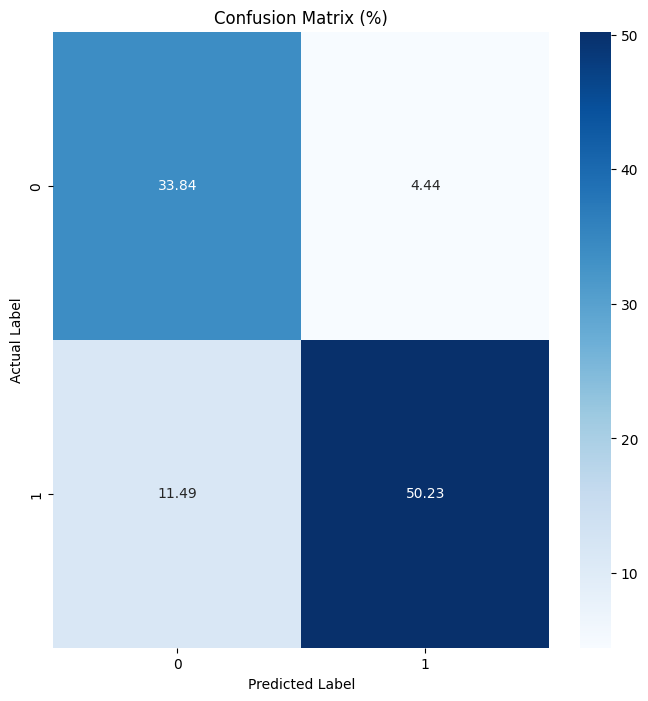

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict and convert probabilities to binary predictions
y_pred = model_hybridbis2.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype('int32')

# Flatten y_pred_binary to 1D if it's not already
y_pred_binary = y_pred_binary.flatten()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Normalize the confusion matrix to get percentages
conf_matrix_percentage = conf_matrix / np.sum(conf_matrix) * 100

# Plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', ax=ax, cmap="Blues")
ax.set_ylabel('Actual Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix (%)')

# Set the correct path to the directory where you want to save the file
filename = "/content/drive/MyDrive/models/confusion_matrix_percentage_model_hybrid9bis2.png"

# Save the figure
plt.savefig(filename)
plt.show()


137/137 [==============================] - 2s 18ms/step


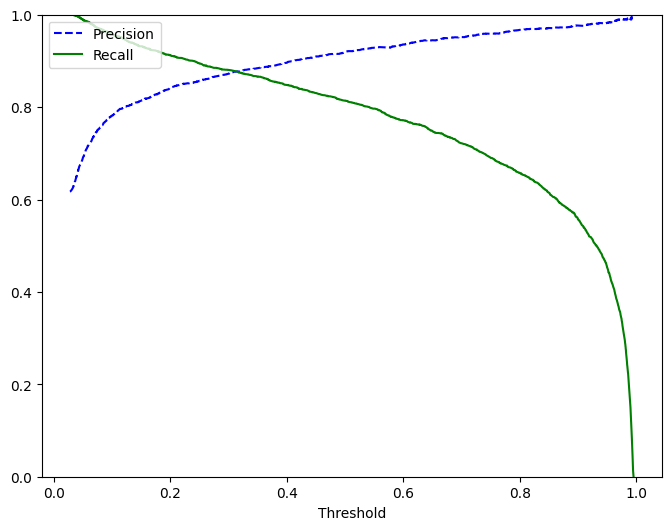

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Ensure X_test is correctly shaped for model predictions
X_test_reshaped = np.expand_dims(X_test, axis=2)  # Add the feature dimension if not already present

# Predict probabilities instead of binary outcomes
y_pred_prob = model_hybridbis2.predict(X_test)
# Assume binary predictions for the threshold of 0.5
y_pred_binary = (y_pred_prob > 0.5).astype('int32')

# Compute precision and recall values for different threshold values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

# Set the correct path to the directory where you want to save the file
filename = "/content/drive/MyDrive/models/precisionandrecallmodel_hybrid91bis2.png"

# Save the figure
plt.savefig(filename)
plt.show()


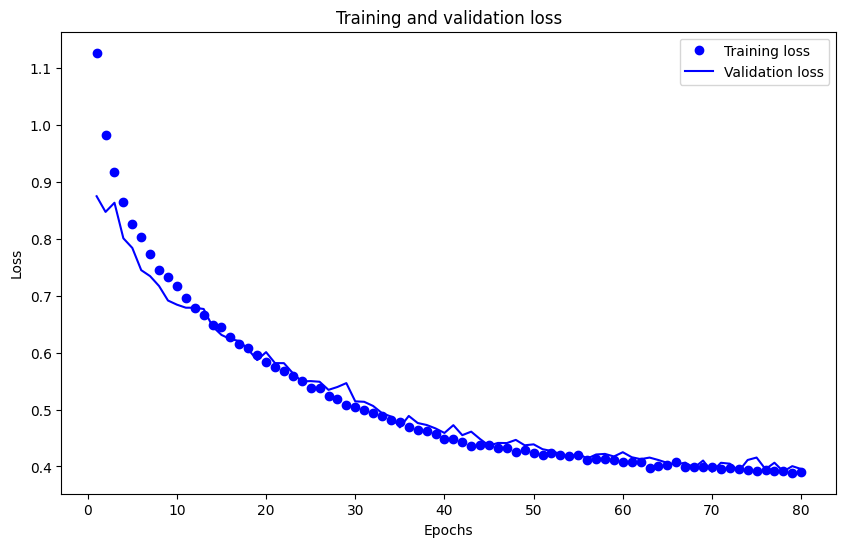

In [ ]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned from the 'fit' method
history_dict = history.history

# Extract the loss values for training and validation
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(loss_values) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')  # 'bo' means blue color, dot markers
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')  # 'b' means blue color, solid line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Before saving to Google Drive, ensure that your Google Drive is mounted
# Set the correct path to the directory where you want to save the file
filename = "/content/drive/MyDrive/models/training_loss_model_hybrid9bis2.png"

# Save the figure to Google Drive
plt.savefig(filename)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Ensure X_test is correctly shaped for model predictions
X_test_reshaped = np.expand_dims(X_test, axis=2)

# Predict probabilities
y_probs = model_hybridbis2.predict(X_test)

# Calculate precision-recall pairs for different threshold values
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
# Find the threshold that corresponds to the maximum F1 score
best_threshold = thresholds[max_f1_index]

print(f"Best threshold by F1 score: {best_threshold}")


137/137 [==============================] - 2s 18ms/step
Best threshold by F1 score: 0.30392545461654663
